#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

from tqdm import tqdm
import os

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA
from scipy.stats import levene, ttest_ind

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Aish_celltypeRNN/Dales-backprop')

Mounted at /content/drive


In [5]:
from data_loader import makeTensorLoaders

#### Test for CUDA

In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Model and related hyper-params

In [7]:
nRuns = 5

batch_size = 200 ##100

latent_scaling = 16
pop_list_types = [12,2,1]

In [8]:
n_areas = 2
n_depths = 3

## Number of recurrent neurons in total
N = int(n_areas*n_depths*np.sum(pop_list_types)*latent_scaling)

#### Data for nRuns

In [9]:
suffix = 'familiar_change'
default_path = '/content/drive/MyDrive/Aish_celltypeRNN/data-processing/averaged_' + suffix + '/train_test/'

pp = '/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen/'

store_path = '/content/drive/My Drive/Aish_celltypeRNN/Storage/Single_RNN/'

In [10]:
# Loading fitting data
dff_V1_L4_sst_train = np.load(default_path + 'dff_V1_L4_sst_' + suffix + '_train.npy')
dff_V1_L23_sst_train = np.load(default_path +'dff_V1_L23_sst_' + suffix + '_train.npy')
dff_V1_L5_sst_train = np.load(default_path +'dff_V1_L5_sst_' + suffix + '_train.npy')

dff_V1_L4_vip_train = np.load(default_path +'dff_V1_L4_vip_' + suffix + '_train.npy')
dff_V1_L23_vip_train = np.load(default_path +'dff_V1_L23_vip_' + suffix + '_train.npy')
dff_V1_L5_vip_train = np.load(default_path +'dff_V1_L5_vip_' + suffix + '_train.npy')

dff_V1_L4_pyr_train = np.load(default_path +'dff_V1_L4_pyr_' + suffix + '_train.npy')
dff_V1_L23_pyr_train = np.load(default_path +'dff_V1_L23_pyr_' + suffix + '_train.npy')
dff_V1_L5_pyr_train = np.load(default_path +'dff_V1_L5_pyr_' + suffix + '_train.npy')

dff_LM_L4_sst_train = np.load(default_path +'dff_LM_L4_sst_' + suffix + '_train.npy')
dff_LM_L23_sst_train = np.load(default_path +'dff_LM_L23_sst_' + suffix + '_train.npy')
dff_LM_L5_sst_train = np.load(default_path +'dff_LM_L5_sst_' + suffix + '_train.npy')

dff_LM_L4_vip_train = np.load(default_path +'dff_LM_L4_vip_' + suffix + '_train.npy')
dff_LM_L23_vip_train = np.load(default_path +'dff_LM_L23_vip_' + suffix + '_train.npy')
dff_LM_L5_vip_train = np.load(default_path +'dff_LM_L5_vip_' + suffix + '_train.npy')

dff_LM_L4_pyr_train = np.load(default_path +'dff_LM_L4_pyr_' + suffix + '_train.npy')
dff_LM_L23_pyr_train = np.load(default_path +'dff_LM_L23_pyr_' + suffix + '_train.npy')
dff_LM_L5_pyr_train = np.load(default_path +'dff_LM_L5_pyr_' + suffix + '_train.npy')

# Loading predictive data
dff_V1_L4_pyr_test = np.load(default_path +'dff_V1_L4_pyr_' + suffix + '_test.npy')
dff_V1_L23_pyr_test = np.load(default_path +'dff_V1_L23_pyr_' + suffix + '_test.npy')
dff_V1_L5_pyr_test = np.load(default_path +'dff_V1_L5_pyr_' + suffix + '_test.npy')

dff_V1_L4_sst_test = np.load(default_path +'dff_V1_L4_sst_' + suffix + '_test.npy')
dff_V1_L23_sst_test = np.load(default_path +'dff_V1_L23_sst_' + suffix + '_test.npy')
dff_V1_L5_sst_test = np.load(default_path +'dff_V1_L5_sst_' + suffix + '_test.npy')

dff_V1_L4_vip_test = np.load(default_path +'dff_V1_L4_vip_' + suffix + '_test.npy')
dff_V1_L23_vip_test = np.load(default_path +'dff_V1_L23_vip_' + suffix + '_test.npy')
dff_V1_L5_vip_test = np.load(default_path +'dff_V1_L5_vip_' + suffix + '_test.npy')

dff_LM_L4_pyr_test = np.load(default_path +'dff_LM_L4_pyr_' + suffix + '_test.npy')
dff_LM_L23_pyr_test = np.load(default_path +'dff_LM_L23_pyr_' + suffix + '_test.npy')
dff_LM_L5_pyr_test = np.load(default_path +'dff_LM_L5_pyr_' + suffix + '_test.npy')

dff_LM_L4_sst_test = np.load(default_path +'dff_LM_L4_sst_' + suffix + '_test.npy')
dff_LM_L23_sst_test = np.load(default_path +'dff_LM_L23_sst_' + suffix + '_test.npy')
dff_LM_L5_sst_test = np.load(default_path +'dff_LM_L5_sst_' + suffix + '_test.npy')

dff_LM_L4_vip_test = np.load(default_path +'dff_LM_L4_vip_' + suffix + '_test.npy')
dff_LM_L23_vip_test = np.load(default_path +'dff_LM_L23_vip_' + suffix + '_test.npy')
dff_LM_L5_vip_test = np.load(default_path +'dff_LM_L5_vip_' + suffix + '_test.npy')

In [ ]:
# stacked_train_set = {}
# stacked_test_set = {}

In [11]:
stacked_train_set = np.dstack((dff_V1_L4_pyr_train, dff_V1_L4_sst_train, dff_V1_L4_vip_train,
                               dff_V1_L23_pyr_train, dff_V1_L23_sst_train, dff_V1_L23_vip_train,
                               dff_V1_L5_pyr_train, dff_V1_L5_sst_train, dff_V1_L5_vip_train,
                               dff_LM_L4_pyr_train, dff_LM_L4_sst_train, dff_LM_L4_vip_train,
                               dff_LM_L23_pyr_train, dff_LM_L23_sst_train, dff_LM_L23_vip_train,
                               dff_LM_L5_pyr_train, dff_LM_L5_sst_train, dff_LM_L5_vip_train))

In [12]:
stacked_test_set = np.dstack((dff_V1_L4_pyr_test, dff_V1_L4_sst_test, dff_V1_L4_vip_test,
                               dff_V1_L23_pyr_test, dff_V1_L23_sst_test, dff_V1_L23_vip_test,
                               dff_V1_L5_pyr_test, dff_V1_L5_sst_test, dff_V1_L5_vip_test,
                               dff_LM_L4_pyr_test, dff_LM_L4_sst_test, dff_LM_L4_vip_test,
                               dff_LM_L23_pyr_test, dff_LM_L23_sst_test, dff_LM_L23_vip_test,
                               dff_LM_L5_pyr_test, dff_LM_L5_sst_test, dff_LM_L5_vip_test))

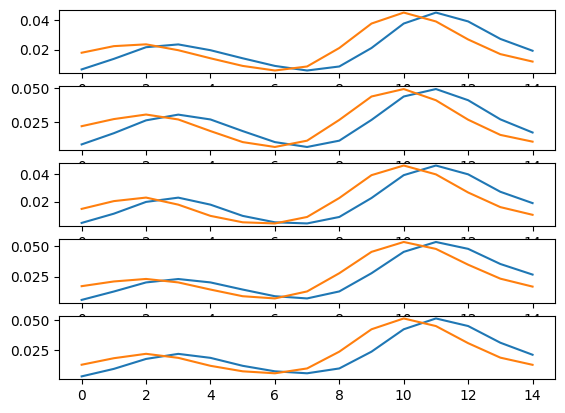

In [13]:
for ii, idxs in enumerate(range(25,30)):
    plt.subplot(5,1,ii+1)
    plt.plot(dff_V1_L4_pyr_train[idxs])
    plt.plot(dff_V1_L4_pyr_test[idxs])

In [14]:
train_loader = {}

In [15]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((stacked_train_set,stacked_test_set),
                                           batch_size,shuffle=True)

#### Block indices

In [16]:
label_arr = ['V1_L4_pyr','V1_L4_sst','V1_L4_vip',
             'V1_L23_pyr','V1_L23_sst','V1_L23_vip',
             'V1_L5_pyr','V1_L5_sst','V1_L5_vip',
             'LM_L4_pyr','LM_L4_sst','LM_L4_vip',
             'LM_L23_pyr','LM_L23_sst','LM_L23_vip',
             'LM_L5_pyr','LM_L5_sst','LM_L5_vip']

In [17]:
n_cell_types = len(label_arr)

In [18]:
start_V1_L4_Pyr = 0
end_V1_L4_Pyr = start_V1_L4_Pyr + pop_list_types[0]*latent_scaling

start_V1_L4_SST = end_V1_L4_Pyr
end_V1_L4_SST = start_V1_L4_SST + pop_list_types[1]*latent_scaling

start_V1_L4_VIP = end_V1_L4_SST
end_V1_L4_VIP = start_V1_L4_VIP + pop_list_types[2]*latent_scaling

## V1, L2/3
start_V1_L23_Pyr = end_V1_L4_VIP
end_V1_L23_Pyr = start_V1_L23_Pyr + pop_list_types[0]*latent_scaling

start_V1_L23_SST = end_V1_L23_Pyr
end_V1_L23_SST = start_V1_L23_SST + pop_list_types[1]*latent_scaling

start_V1_L23_VIP = end_V1_L23_SST
end_V1_L23_VIP = start_V1_L23_VIP + pop_list_types[2]*latent_scaling

## V1, L5
start_V1_L5_Pyr = end_V1_L23_VIP
end_V1_L5_Pyr = start_V1_L5_Pyr + pop_list_types[0]*latent_scaling

start_V1_L5_SST = end_V1_L5_Pyr
end_V1_L5_SST = start_V1_L5_SST + pop_list_types[1]*latent_scaling

start_V1_L5_VIP = end_V1_L5_SST
end_V1_L5_VIP = start_V1_L5_VIP + pop_list_types[2]*latent_scaling

## LM, L4
start_LM_L4_Pyr = end_V1_L5_VIP ## would need to be changed if using L6 populations as well
end_LM_L4_Pyr = start_LM_L4_Pyr + pop_list_types[0]*latent_scaling

start_LM_L4_SST = end_LM_L4_Pyr
end_LM_L4_SST = start_LM_L4_SST + pop_list_types[1]*latent_scaling

start_LM_L4_VIP = end_LM_L4_SST
end_LM_L4_VIP = start_LM_L4_VIP + pop_list_types[2]*latent_scaling

## LM, L2/3
start_LM_L23_Pyr = end_LM_L4_VIP
end_LM_L23_Pyr = start_LM_L23_Pyr + pop_list_types[0]*latent_scaling

start_LM_L23_SST = end_LM_L23_Pyr
end_LM_L23_SST = start_LM_L23_SST + pop_list_types[1]*latent_scaling

start_LM_L23_VIP = end_LM_L23_SST
end_LM_L23_VIP = start_LM_L23_VIP + pop_list_types[2]*latent_scaling

## LM, L5
start_LM_L5_Pyr = end_LM_L23_VIP
end_LM_L5_Pyr = start_LM_L5_Pyr + pop_list_types[0]*latent_scaling

start_LM_L5_SST = end_LM_L5_Pyr
end_LM_L5_SST = start_LM_L5_SST + pop_list_types[1]*latent_scaling

start_LM_L5_VIP = end_LM_L5_SST
end_LM_L5_VIP = start_LM_L5_VIP + pop_list_types[2]*latent_scaling

#### Architecture

In [19]:
# Define the neural network
class CelltypeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):

        super(CelltypeRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh', bias=False)

        self.fc1 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc2 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc3 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc4 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc5 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc6 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc7 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc8 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc9 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)

        self.fc10 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc11 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc12 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc13 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc14 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc15 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)
        self.fc16 = nn.Linear(round(pop_list_types[0]*latent_scaling), num_classes)
        self.fc17 = nn.Linear(round(pop_list_types[1]*latent_scaling), num_classes)
        self.fc18 = nn.Linear(round(pop_list_types[2]*latent_scaling), num_classes)

        self.fc1.weight.requires_grad = False
        self.fc1.bias.requires_grad = False

        self.fc2.weight.requires_grad = False
        self.fc2.bias.requires_grad = False

        self.fc3.weight.requires_grad = False
        self.fc3.bias.requires_grad = False

        self.fc4.weight.requires_grad = False
        self.fc4.bias.requires_grad = False

        self.fc5.weight.requires_grad = False
        self.fc5.bias.requires_grad = False

        self.fc6.weight.requires_grad = False
        self.fc6.bias.requires_grad = False

        self.fc7.weight.requires_grad = False
        self.fc7.bias.requires_grad = False

        self.fc8.weight.requires_grad = False
        self.fc8.bias.requires_grad = False

        self.fc9.weight.requires_grad = False
        self.fc9.bias.requires_grad = False

        self.fc10.weight.requires_grad = False
        self.fc10.bias.requires_grad = False

        self.fc11.weight.requires_grad = False
        self.fc11.bias.requires_grad = False

        self.fc12.weight.requires_grad = False
        self.fc12.bias.requires_grad = False

        self.fc13.weight.requires_grad = False
        self.fc13.bias.requires_grad = False

        self.fc14.weight.requires_grad = False
        self.fc14.bias.requires_grad = False

        self.fc15.weight.requires_grad = False
        self.fc15.bias.requires_grad = False

        self.fc16.weight.requires_grad = False
        self.fc16.bias.requires_grad = False

        self.fc17.weight.requires_grad = False
        self.fc17.bias.requires_grad = False

        self.fc18.weight.requires_grad = False
        self.fc18.bias.requires_grad = False

        self.n_classes = num_classes
        self.device = device

    def forward(self, x):
        ## Define input mask
        in_mask = torch.zeros(self.hidden_size, self.input_size).to(device)
        in_mask[start_V1_L4_Pyr:end_V1_L4_Pyr,0] = 1
        in_mask[start_V1_L4_SST:end_V1_L4_SST,1] = 1
        in_mask[start_V1_L4_VIP:end_V1_L4_VIP,2] = 1

        in_mask[start_V1_L23_Pyr:end_V1_L23_Pyr,3] = 1
        in_mask[start_V1_L23_SST:end_V1_L23_SST,4] = 1
        in_mask[start_V1_L23_VIP:end_V1_L23_VIP,5] = 1

        in_mask[start_V1_L5_Pyr:end_V1_L5_Pyr,6] = 1
        in_mask[start_V1_L5_SST:end_V1_L5_SST,7] = 1
        in_mask[start_V1_L5_VIP:end_V1_L5_VIP,8] = 1

        in_mask[start_LM_L4_Pyr:end_LM_L4_Pyr,9] = 1
        in_mask[start_LM_L4_SST:end_LM_L4_SST,10] = 1
        in_mask[start_LM_L4_VIP:end_LM_L4_VIP,11] = 1

        in_mask[start_LM_L23_Pyr:end_LM_L23_Pyr,12] = 1
        in_mask[start_LM_L23_SST:end_LM_L23_SST,13] = 1
        in_mask[start_LM_L23_VIP:end_LM_L23_VIP,14] = 1

        in_mask[start_LM_L5_Pyr:end_LM_L5_Pyr,15] = 1
        in_mask[start_LM_L5_SST:end_LM_L5_SST,16] = 1
        in_mask[start_LM_L5_VIP:end_LM_L5_VIP,17] = 1

        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, inDim, nSteps = x.shape

        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)

        pred1 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred2 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred3 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred4 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred5 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred6 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred7 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred8 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred9 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)

        pred10 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred11 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred12 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred13 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred14 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred15 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred16 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred17 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred18 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)

        for ii in range(nSteps):
            ## Apply input mask
            self.rnn.weight_ih_l0.data.mul(in_mask)

            ip = torch.unsqueeze(x[:,:,ii],-1).view(nSamp,1,inDim)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred1[:,ii,:] = self.fc1(ops[:, ii, start_V1_L4_Pyr:end_V1_L4_Pyr].clone())
            pred2[:,ii,:] = self.fc2(ops[:, ii, start_V1_L4_SST:end_V1_L4_SST].clone())
            pred3[:,ii,:] = self.fc3(ops[:, ii, start_V1_L4_VIP:end_V1_L4_VIP].clone())
            pred4[:,ii,:] = self.fc4(ops[:, ii, start_V1_L23_Pyr:end_V1_L23_Pyr].clone())
            pred5[:,ii,:] = self.fc5(ops[:, ii, start_V1_L23_SST:end_V1_L23_SST].clone())
            pred6[:,ii,:] = self.fc6(ops[:, ii, start_V1_L23_VIP:end_V1_L23_VIP].clone())
            pred7[:,ii,:] = self.fc7(ops[:, ii, start_V1_L5_Pyr:end_V1_L5_Pyr].clone())
            pred8[:,ii,:] = self.fc8(ops[:, ii, start_V1_L5_SST:end_V1_L5_SST].clone())
            pred9[:,ii,:] = self.fc9(ops[:, ii, start_V1_L5_VIP:end_V1_L5_VIP].clone())

            pred10[:,ii,:] = self.fc10(ops[:, ii, start_LM_L4_Pyr:end_LM_L4_Pyr].clone())
            pred11[:,ii,:] = self.fc11(ops[:, ii, start_LM_L4_SST:end_LM_L4_SST].clone())
            pred12[:,ii,:] = self.fc12(ops[:, ii, start_LM_L4_VIP:end_LM_L4_VIP].clone())
            pred13[:,ii,:] = self.fc13(ops[:, ii, start_LM_L23_Pyr:end_LM_L23_Pyr].clone())
            pred14[:,ii,:] = self.fc14(ops[:, ii, start_LM_L23_SST:end_LM_L23_SST].clone())
            pred15[:,ii,:] = self.fc15(ops[:, ii, start_LM_L23_VIP:end_LM_L23_VIP].clone())
            pred16[:,ii,:] = self.fc16(ops[:, ii, start_LM_L5_Pyr:end_LM_L5_Pyr].clone())
            pred17[:,ii,:] = self.fc17(ops[:, ii, start_LM_L5_SST:end_LM_L5_SST].clone())
            pred18[:,ii,:] = self.fc18(ops[:, ii, start_LM_L5_VIP:end_LM_L5_VIP].clone())

        out1 = pred1.clone() #Take the output from the last time step
        out2 = pred2.clone() #Take the output from the last time step
        out3 = pred3.clone() #Take the output from the last time step
        out4 = pred4.clone() #Take the output from the last time step
        out5 = pred5.clone() #Take the output from the last time step
        out6 = pred6.clone() #Take the output from the last time step
        out7 = pred7.clone() #Take the output from the last time step
        out8 = pred8.clone() #Take the output from the last time step
        out9 = pred9.clone() #Take the output from the last time step

        out10 = pred10.clone() #Take the output from the last time step
        out11 = pred11.clone() #Take the output from the last time step
        out12 = pred12.clone() #Take the output from the last time step
        out13 = pred13.clone() #Take the output from the last time step
        out14 = pred14.clone() #Take the output from the last time step
        out15 = pred15.clone() #Take the output from the last time step
        out16 = pred16.clone() #Take the output from the last time step
        out17 = pred17.clone() #Take the output from the last time step
        out18 = pred18.clone() #Take the output from the last time step

        return torch.dstack((out1,out2, out3, out4, out5, out6, out7, out8, out9,
                             out10,out11, out12, out13, out14, out15, out16, out17, out18)), htt

In [20]:
npp = {}
pp_npy = {}
pp_pts = {}

In [21]:
model_initial= {}
model_dense = {}
model_sparse = {}

In [22]:
for cntr in range(nRuns):

    npp[cntr] = 'celltype-dale-pruning-latent-16-'+str(cntr)+'/'
    pp_npy[cntr] = pp+npp[cntr]+'npys-'+str(cntr)+'/'
    pp_pts[cntr] = pp+npp[cntr]+'pts-'+str(cntr)+'/'


In [23]:
for cntr in range(nRuns):

    path_initial = pp_pts[cntr] + 'celltypeRNN-dale-initial-'+str(latent_scaling)+'.pt'
    path_dense = pp_pts[cntr] + 'celltypeRNN-dale-dense-'+str(latent_scaling)+'.pt'
    path_sparse = pp_pts[cntr] + 'celltypeRNN-dale-sparse-'+str(latent_scaling)+'.pt'
    print(path_initial)

    model_initial[cntr] = CelltypeRNN(18, N, 1, device)
    model_dense[cntr] = CelltypeRNN(18, N, 1, device)
    model_sparse[cntr] = CelltypeRNN(18, N, 1, device)

    model_initial[cntr].load_state_dict(torch.load(path_initial))
    model_dense[cntr].load_state_dict(torch.load(path_dense))
    model_sparse[cntr].load_state_dict(torch.load(path_sparse))

/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen/celltype-dale-pruning-latent-16-0/pts-0/celltypeRNN-dale-initial-16.pt


<ipython-input-23-6993864eb406>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_initial[cntr].load_state_dict(torch.load(path_initial))
<ipython-input-23-6993864eb40

/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen/celltype-dale-pruning-latent-16-1/pts-1/celltypeRNN-dale-initial-16.pt
/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen/celltype-dale-pruning-latent-16-2/pts-2/celltypeRNN-dale-initial-16.pt
/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen/celltype-dale-pruning-latent-16-3/pts-3/celltypeRNN-dale-initial-16.pt
/content/drive/My Drive/Aish_celltypeRNN/Repeated-Runs-Dales-Pruning/Familiar-Change-Sparse-Frozen/celltype-dale-pruning-latent-16-4/pts-4/celltypeRNN-dale-initial-16.pt


#### test on CUDA

In [24]:
for inputs, targets in train_loader[cntr]:
    if train_on_gpu:
        inputs, targets = inputs.float().cuda(), targets.float().cuda()
        inputs = inputs.permute(0,2,1)
        targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))
        model_initial[cntr].cuda()
        model_dense[cntr].cuda()
        model_sparse[cntr].cuda()
    else:
        inputs, targets = inputs.float(), targets.float()
        inputs = inputs.permute(0,2,1)
        targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2,:],
                                  torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5,:],
                                  torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8,:],
                                  torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11,:],
                                  torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14,:],
                                  torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17,:]))

In [ ]:
inputs.shape

torch.Size([200, 18, 15])

In [ ]:
targets.shape

torch.Size([200, 15, 18])

In [ ]:
targets_f.shape

torch.Size([200, 15, 18])

In [ ]:
oo, fr = model_initial[cntr](inputs)

In [ ]:
oo.shape

torch.Size([200, 15, 18])

In [ ]:
fr.shape

torch.Size([1, 200, 1440])

### Testing

In [ ]:
targets_f_batch = {}
inputs_batch = {}

In [ ]:
outputs_initial_collector = []
outputs_dense_collector = []
outputs_sparse_collector = []

targets_f_collector = []

for cntr in range(nRuns):
    print(f'Run: {cntr}')

    for inputs, targets in train_loader[cntr]:
        if train_on_gpu:
            inputs, targets = inputs.float().cuda(), targets.float().cuda()
            inputs = inputs.permute(0,2,1)
            targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                              torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                              torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                              torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                              torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                              torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))
            model_initial[cntr].cuda()
            model_dense[cntr].cuda()
            model_sparse[cntr].cuda()

        else:
            inputs, targets = inputs.float(), targets.float()
            inputs = inputs.permute(0,2,1)
            targets_f = torch.dstack((torch.squeeze(targets)[:,:,0],torch.squeeze(targets)[:,:,1],torch.squeeze(targets)[:,:,2],
                              torch.squeeze(targets)[:,:,3],torch.squeeze(targets)[:,:,4],torch.squeeze(targets)[:,:,5],
                              torch.squeeze(targets)[:,:,6],torch.squeeze(targets)[:,:,7],torch.squeeze(targets)[:,:,8],
                              torch.squeeze(targets)[:,:,9],torch.squeeze(targets)[:,:,10],torch.squeeze(targets)[:,:,11],
                              torch.squeeze(targets)[:,:,12],torch.squeeze(targets)[:,:,13],torch.squeeze(targets)[:,:,14],
                              torch.squeeze(targets)[:,:,15],torch.squeeze(targets)[:,:,16],torch.squeeze(targets)[:,:,17]))


        outputs_initial, firing_rates_initial = model_initial[cntr](inputs)
        outputs_dense, firing_rates_dense = model_dense[cntr](inputs)
        outputs_sparse, firing_rates_sparse = model_sparse[cntr](inputs)

        outputs_initial = torch.squeeze(outputs_initial)
        outputs_dense = torch.squeeze(outputs_dense)
        outputs_sparse = torch.squeeze(outputs_sparse)

        outputs_initial_collector.append(outputs_initial.detach().cpu().numpy())
        outputs_dense_collector.append(outputs_dense.detach().cpu().numpy())
        outputs_sparse_collector.append(outputs_sparse.detach().cpu().numpy())
        targets_f_collector.append(targets_f.detach().cpu().numpy())


Run: 0
Run: 1
Run: 2
Run: 3
Run: 4


## First we show the training result

In [ ]:
outputs_np, targets_np = outputs_initial_collector[1], targets_f_collector[1]

In [ ]:
outputs_np.shape

(200, 15, 18)

In [ ]:
targets_np.shape

(200, 15, 18)

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os

In [ ]:
#prediction_path = '/content/drive/My Drive/Aish_celltypeRNN/Storage/Single_RNN/prediction/'+suffix + '/'
#os.mkdir(prediction_path)

Text(0.5, 1.0, 'LM_L4_sst')

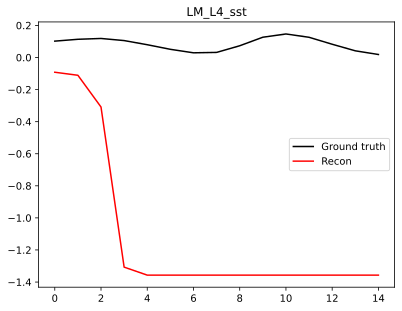

In [ ]:
ex = 2
ii = 10

# target_batch = targets_np[ii*batch_size:(ii+1)*batch_size]
target_curve = targets_np[ex,:,ii]
plt.plot(target_curve,color='k',label='Ground truth')

# output_batch = outputs_np[ii*batch_size:(ii+1)*batch_size]
output_curve = outputs_np[ex,:,ii]
plt.plot(output_curve, color='r',label='Recon')
plt.legend()
plt.title(label_arr[ii])

In [42]:
label_arr_f = ['V1 L4 pyr','V1 L4 sst','V1 L4 vip',
             'V1 L23 pyr','V1 L23 sst','V1 L23 vip',
             'V1 L5 pyr','V1 L5 sst','V1 L5 vip',
             'LM L4 pyr','LM L4 sst','LM L4 vip',
             'LM L23 pyr','LM L23 sst','LM L23 vip',
             'LM L5 pyr','LM L5 sst','LM L5 vip']

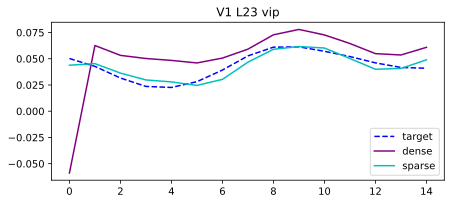

In [ ]:
cntr = 0
outputs_np_initial,outputs_np_dense, outputs_np_sparse, targets_np = outputs_initial_collector[cntr], outputs_dense_collector[cntr], outputs_sparse_collector[cntr], targets_f_collector[cntr]

ex = 0 # pick one random trial
plt.figure(figsize=(24,20))

ii = 5
plt.subplot(6,3,ii+1)

target_curve = targets_np[ex,:,ii]
plt.plot(target_curve,color='b', label='target', linestyle='--')

output_curve_initial = outputs_np_initial[ex,:,ii]
#plt.plot(output_curve_initial,color='r', label='initial')

output_curve_dense = outputs_np_dense[ex,:,ii]
plt.plot(output_curve_dense,color='purple', label='dense', )

output_curve_sparse = outputs_np_sparse[ex,:,ii]
plt.plot(output_curve_sparse,color='c', label='sparse')

plt.title(label_arr_f[ii])
plt.legend()

plt.savefig(store_path +''+ '.svg', format='svg')





In [ ]:
# plot them separately
cntr = 0
outputs_np_initial,outputs_np_dense, outputs_np_sparse, targets_np = outputs_initial_collector[cntr], outputs_dense_collector[cntr], outputs_sparse_collector[cntr], targets_f_collector[cntr]

ex = 0 # pick one random trial
#plt.figure(figsize=(24,20))

for ii in range(n_cell_types):
    #plt.subplot(6,3,ii+1)
    plt.figure(figsize=(12,6))

    target_curve = targets_np[ex,:,ii]
    plt.plot(target_curve,color='black', label='target', linestyle='--')

    output_curve_initial = outputs_np_initial[ex,:,ii]
    #plt.plot(output_curve_initial,color='r', label='initial')

    output_curve_dense = outputs_np_dense[ex,:,ii]
    plt.plot(output_curve_dense,color='gray', label='dense')

    output_curve_sparse = outputs_np_sparse[ex,:,ii]
    plt.plot(output_curve_sparse,color='green', label='sparse')

    plt.title(label_arr_f[ii])
    plt.legend()
    plt.savefig(store_path + 'prediction/'+ suffix + '/predict_'+label_arr[ii]+ '.svg', format='svg')
    plt.close()

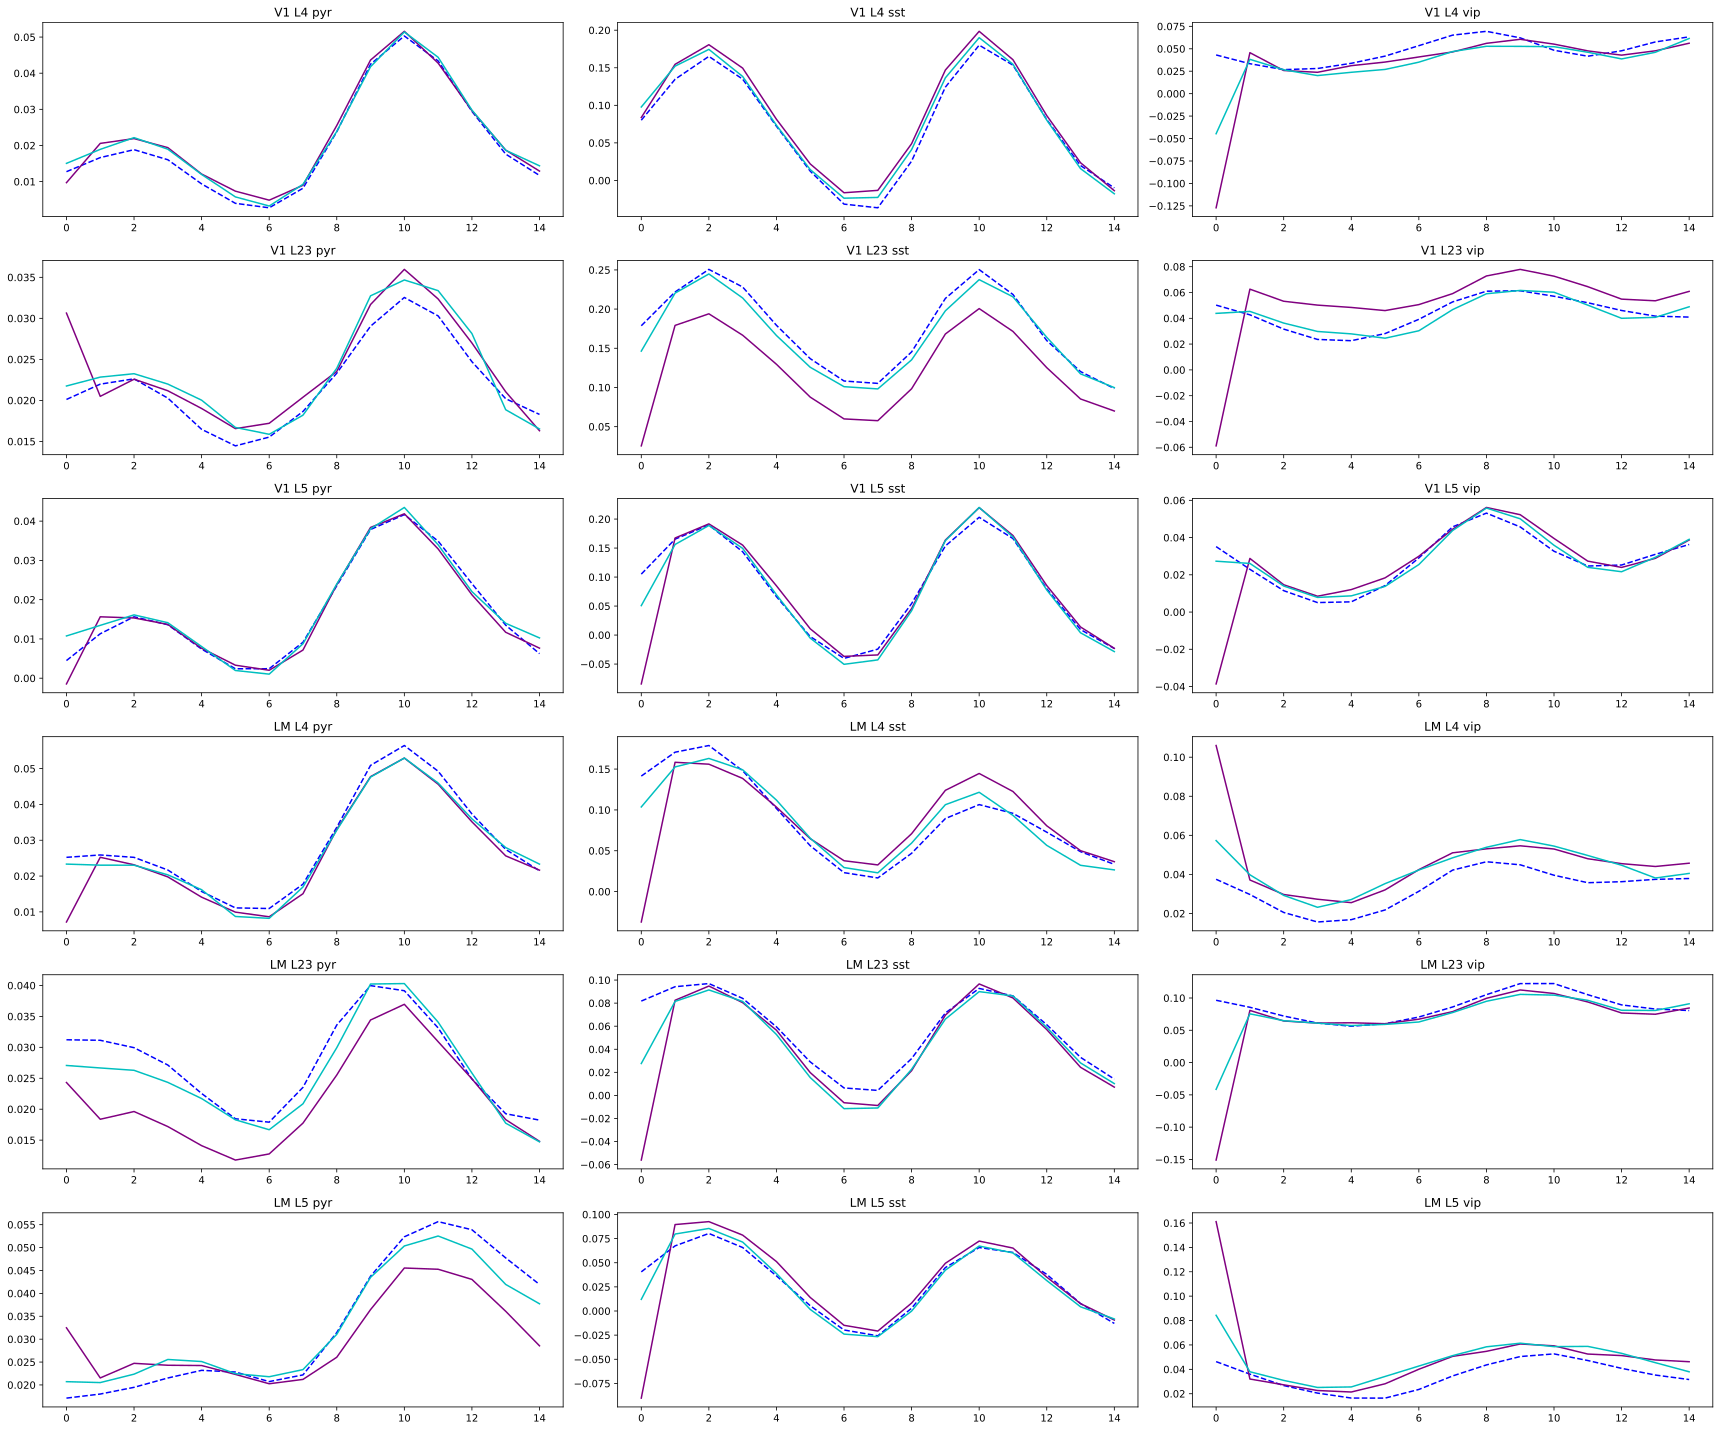

In [ ]:
# plot them all
cntr = 0
outputs_np_initial,outputs_np_dense, outputs_np_sparse, targets_np = outputs_initial_collector[cntr], outputs_dense_collector[cntr], outputs_sparse_collector[cntr], targets_f_collector[cntr]

ex = 0 # pick one random trial
plt.figure(figsize=(24,20))

for ii in range(n_cell_types):
    plt.subplot(6,3,ii+1)

    target_curve = targets_np[ex,:,ii]
    plt.plot(target_curve,color='black', label='target', linestyle='--')

    output_curve_initial = outputs_np_initial[ex,:,ii]
    #plt.plot(output_curve_initial,color='r', label='initial')

    output_curve_dense = outputs_np_dense[ex,:,ii]
    plt.plot(output_curve_dense,color='gray', label='dense')

    output_curve_sparse = outputs_np_sparse[ex,:,ii]
    plt.plot(output_curve_sparse,color='green', label='sparse')

    plt.title(label_arr_f[ii])
    #plt.legend()
plt.tight_layout()
plt.savefig(store_path + 'prediction/'+ suffix +'/predict_all'+ '.svg', format='svg')

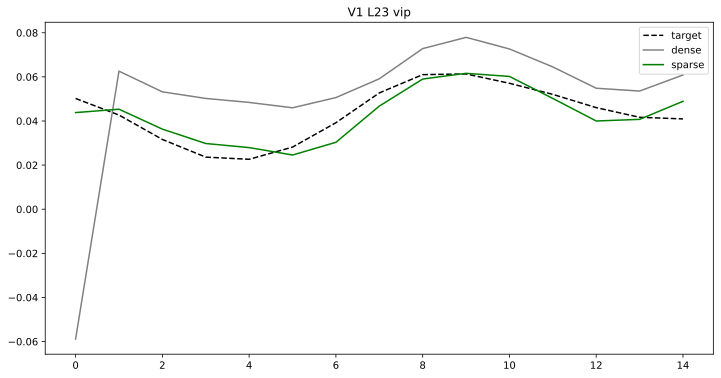

In [ ]:
cntr = 0
outputs_np_initial,outputs_np_dense, outputs_np_sparse, targets_np = outputs_initial_collector[cntr], outputs_dense_collector[cntr], outputs_sparse_collector[cntr], targets_f_collector[cntr]

ex = 0 # pick one random trial
plt.figure(figsize=(12,6))

ii = 5

target_curve = targets_np[ex,:,ii]
plt.plot(target_curve,color='black', label='target', linestyle='--')

output_curve_initial = outputs_np_initial[ex,:,ii]
#plt.plot(output_curve_initial,color='r', label='initial')

output_curve_dense = outputs_np_dense[ex,:,ii]
plt.plot(output_curve_dense,color='gray', label='dense', )

output_curve_sparse = outputs_np_sparse[ex,:,ii]
plt.plot(output_curve_sparse,color='green', label='sparse')

plt.title(label_arr_f[ii])
plt.legend()

plt.savefig(store_path +''+ '.svg', format='svg')


In [ ]:
cntr = 0
outputs_np_initial,outputs_np_dense, outputs_np_sparse, targets_np = outputs_initial_collector[cntr], outputs_dense_collector[cntr], outputs_sparse_collector[cntr], targets_f_collector[cntr]

ex = 0 # pick one random trial
#plt.figure(figsize=(24,20))

for ii in range(n_cell_types):
    #plt.subplot(6,3,ii+1)
    plt.figure(figsize=(12,6))
    target_curve = targets_np[ex,:,ii]
    plt.plot(target_curve,color='black', label='target', linestyle='--')

    output_curve_initial = outputs_np_initial[ex,:,ii]
    #plt.plot(output_curve_initial,color='r', label='initial')

    output_curve_dense = outputs_np_dense[ex,:,ii]
    plt.plot(output_curve_dense,color='gray', label='dense')

    output_curve_sparse = outputs_np_sparse[ex,:,ii]
    plt.plot(output_curve_sparse,color='green', label='sparse')

    plt.title(label_arr_f[ii])
    plt.legend()
    plt.savefig(store_path +'another_cmap/' +'predict_'+label_arr[ii]+ '.svg', format='svg')
    plt.close()

# then let's do the weight analysis!

In [25]:
conn_mtx_initial = {}
conn_mtx_dense = {}
conn_mtx_sparse = {}

In [26]:
# conn_mtx_final = (model[0].rnn._parameters['weight_hh_l0'].cpu().detach().numpy())
# conn_mtx_init = weights_init[0]

In [27]:
for cntr in range(nRuns):
    conn_mtx_initial[cntr] = (model_initial[cntr].rnn._parameters['weight_hh_l0'].cpu().detach().numpy())
    conn_mtx_dense[cntr] = (model_dense[cntr].rnn._parameters['weight_hh_l0'].cpu().detach().numpy())
    conn_mtx_sparse[cntr] = (model_sparse[cntr].rnn._parameters['weight_hh_l0'].cpu().detach().numpy())

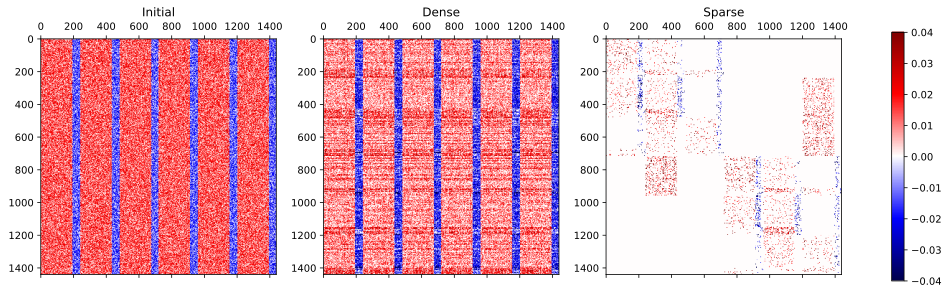

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cmap = 'seismic'
vmin, vmax = -0.04, 0.04
run = 0

# Initial matrix
img1 = axes[0].matshow(conn_mtx_initial[run], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].title.set_text('Initial')

# Dense matrix
img2 = axes[1].matshow(conn_mtx_dense[run], vmin=vmin, vmax=vmax, cmap=cmap)
axes[1].title.set_text('Dense')

# Sparse matrix
img3 = axes[2].matshow(conn_mtx_sparse[run], vmin=vmin, vmax=vmax, cmap=cmap)
axes[2].title.set_text('Sparse')

# Add a colorbar to the right of the subplots
fig.colorbar(img3, ax=axes.ravel().tolist(), shrink=0.75, orientation='vertical')

# Save the figure
plt.savefig(store_path + 'connectivity/' + suffix + '.svg', format='svg')
plt.show()


<ipython-input-33-98162f99b054>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)
<ipython-input-33-98162f99b054>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(133)


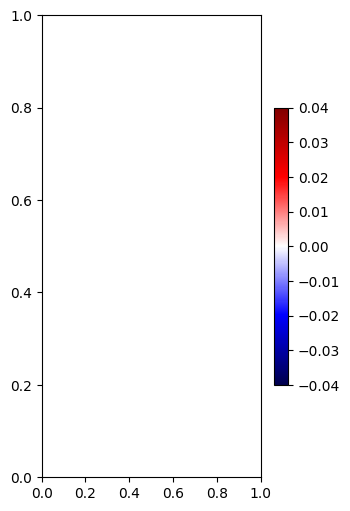

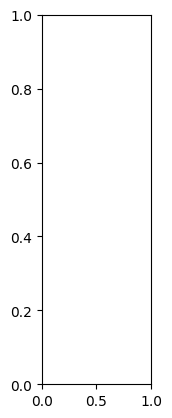

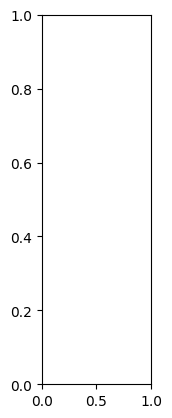

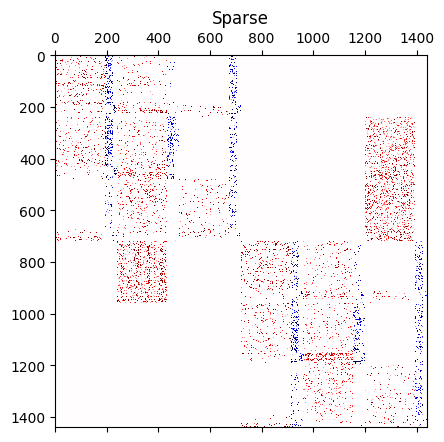

In [33]:
'''# Create the figure
ff = plt.figure(figsize=(12, 6))
#cmap='bwr'
cmap = 'seismic'

run = 0

# Set the color limits before plotting
vmin, vmax = -0.04, 0.04

# Plot the initial matrix
plt.subplot(131)
img1 = plt.imshow(conn_mtx_initial[run], vmin=vmin, vmax=vmax, cmap=cmap)
plt.title("Initial")

# Plot the dense matrix
plt.subplot(132)
img2 = plt.imshow(conn_mtx_dense[run], vmin=vmin, vmax=vmax, cmap=cmap)
plt.title("Dense")

# Plot the sparse matrix
plt.subplot(133)
img3 = plt.imshow(conn_mtx_sparse[run], vmin=vmin, vmax=vmax, cmap=cmap)
plt.title("Sparse")

# Add a colorbar
#ff.colorbar(img3, ax=ax3)
ff.colorbar(img3, ax=ff.axes, orientation='vertical', shrink=0.6)

plt.savefig(store_path +'connectivity/' +suffix+'.svg', format='svg')'''

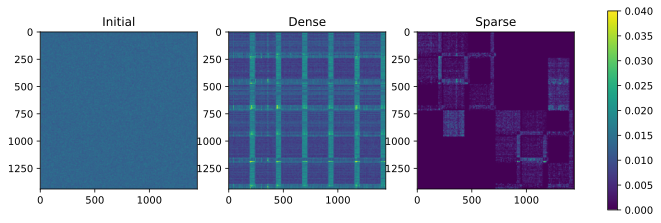

In [ ]:
# the absolute is coming
ff = plt.figure(figsize=(12, 6))

run = 0

# Set the color limits before plotting
vmin, vmax = 0, 0.04

# Plot the initial matrix
plt.subplot(131)
img1 = plt.imshow(abs(conn_mtx_initial[run]), vmin=vmin, vmax=vmax)
plt.title("Initial")

# Plot the dense matrix
plt.subplot(132)
img2 = plt.imshow(abs(conn_mtx_dense[run]), vmin=vmin, vmax=vmax)
plt.title("Dense")

# Plot the sparse matrix
plt.subplot(133)
img3 = plt.imshow(abs(conn_mtx_sparse[run]), vmin=vmin, vmax=vmax)
plt.title("Sparse")

# Add a colorbar
#ff.colorbar(img3, ax=ax3)
ff.colorbar(img3, ax=ff.axes, orientation='vertical', shrink=0.6)

# Show the plot
plt.show()

In [43]:
def average_weights_in_blocks_matrix(weight_matrix, block_indices, use_absolute_values=False):
    n_blocks = len(block_indices)
    averages_matrix = np.zeros((n_blocks, n_blocks))

    for i, (start_i, end_i) in enumerate(block_indices):
        for j, (start_j, end_j) in enumerate(block_indices):
            block_weights = weight_matrix[start_i:end_i, start_j:end_j]  # Extract the block of weights ##had +1 at end_js

            if use_absolute_values:
                block_weights = np.abs(block_weights)

            block_average = np.mean(block_weights)  # Calculate the average
            averages_matrix[i, j] = block_average

    return averages_matrix

In [44]:
block_indices = [(start_V1_L4_Pyr,end_V1_L4_Pyr), (start_V1_L4_SST,end_V1_L4_SST), (start_V1_L4_VIP,end_V1_L4_VIP),
                 (start_V1_L23_Pyr,end_V1_L23_Pyr), (start_V1_L23_SST,end_V1_L23_SST), (start_V1_L23_VIP,end_V1_L23_VIP),
                 (start_V1_L5_Pyr,end_V1_L5_Pyr), (start_V1_L5_SST,end_V1_L5_SST), (start_V1_L5_VIP,end_V1_L5_VIP),
                 (start_LM_L4_Pyr,end_LM_L4_Pyr), (start_LM_L4_SST,end_LM_L4_SST), (start_LM_L4_VIP,end_LM_L4_VIP),
                 (start_LM_L23_Pyr,end_LM_L23_Pyr), (start_LM_L23_SST,end_LM_L23_SST), (start_LM_L23_VIP,end_LM_L23_VIP),
                 (start_LM_L5_Pyr,end_LM_L5_Pyr), (start_LM_L5_SST,end_LM_L5_SST), (start_LM_L5_VIP,end_LM_L5_VIP)]

In [45]:
block_indices_layers = [(start_V1_L4_Pyr,end_V1_L4_VIP), (start_V1_L23_Pyr,end_V1_L23_VIP), (start_V1_L5_Pyr,end_V1_L5_VIP),
                        (start_LM_L4_Pyr,end_LM_L4_VIP), (start_LM_L23_Pyr,end_LM_L23_VIP), (start_LM_L5_Pyr,end_LM_L5_VIP)]

In [46]:
label_arr_layers = ['V1_L4', 'V1_L23', 'V1_L5', 'LM_L4', 'LM_L23', 'LM_L5']

In [47]:
block_indices_areas = [(start_V1_L4_Pyr,end_V1_L5_VIP), (start_LM_L4_Pyr,end_LM_L5_VIP)]

In [48]:
label_arr_areas = ['V1','LM']

In [49]:
cell_types = ['Pyr', 'SST', 'ViP']
layers = ['L4','L2/3','L5']

In [50]:
weights_init = conn_mtx_initial
conn_mtx_final_pruned_retrained = conn_mtx_sparse

In [51]:
av_raw_init_pruned = {}
av_raw_final_pruned = {}

av_abs_init_pruned = {}
av_abs_final_pruned = {}

In [52]:
for cntr in range(nRuns):
    av_raw_init_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices, use_absolute_values=False)
    av_raw_final_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices,
                                                           use_absolute_values=False)

    av_abs_init_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices, use_absolute_values=True)
    av_abs_final_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices,
                                                           use_absolute_values=True)

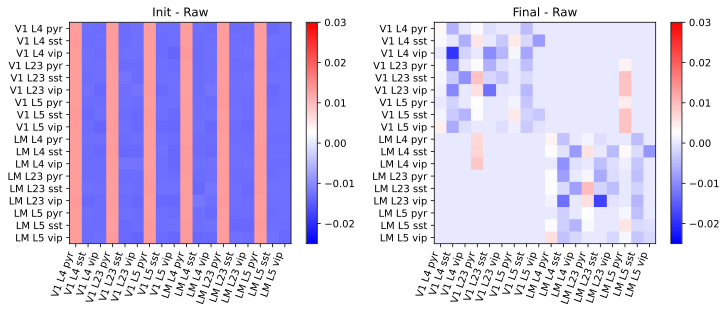

In [57]:
fraw = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_raw_init_pruned[run], cmap='bwr', vmin=av_raw_init_pruned[run].min(), vmax=av_raw_init_pruned[run].max())
plt.title('Init - Raw')
plt.xticks(np.arange(len(label_arr)), label_arr_f, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr_f)
plt.colorbar()
plt.clim(-0.025,0.03)

plt.subplot(122)
plt.imshow(av_raw_final_pruned[run], cmap='bwr', vmin=av_raw_final_pruned[run].min(), vmax=av_raw_final_pruned[run].max())
plt.title('Final - Raw')
plt.xticks(np.arange(len(label_arr)), label_arr_f, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr_f)
plt.colorbar()
plt.clim(-0.025,0.03)

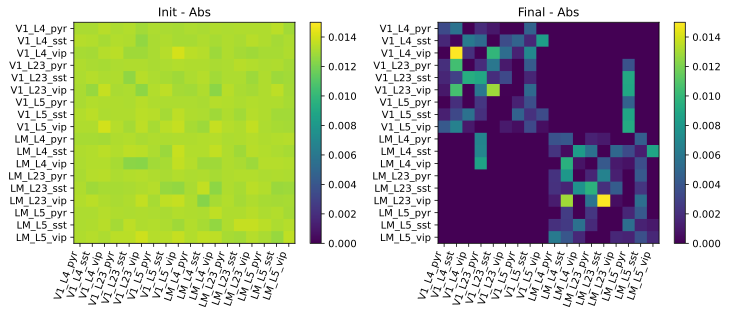

In [58]:
fabs = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_abs_init_pruned[run], cmap='viridis', vmin=av_abs_init_pruned[run].min(), vmax=av_abs_init_pruned[run].max())
plt.title('Init - Abs')
plt.xticks(np.arange(len(label_arr)), label_arr, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr)
plt.colorbar()
plt.clim(0.0,0.015)

plt.subplot(122)
plt.imshow(av_abs_final_pruned[run], cmap='viridis', vmin=av_abs_final_pruned[run].min(), vmax=av_abs_final_pruned[run].max())
plt.title('Final - Abs')
plt.xticks(np.arange(len(label_arr)), label_arr, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr)), label_arr)
plt.colorbar()
plt.clim(0.0,0.015)

In [59]:
av_raw_init_layers_pruned = {}
av_raw_final_layers_pruned = {}

av_abs_init_layers_pruned = {}
av_abs_final_layers_pruned = {}

In [60]:
for cntr in range(nRuns):
    av_raw_init_layers_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_layers, use_absolute_values=False)
    av_raw_final_layers_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_layers, use_absolute_values=False)

    av_abs_init_layers_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_layers, use_absolute_values=True)
    av_abs_final_layers_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_layers, use_absolute_values=True)

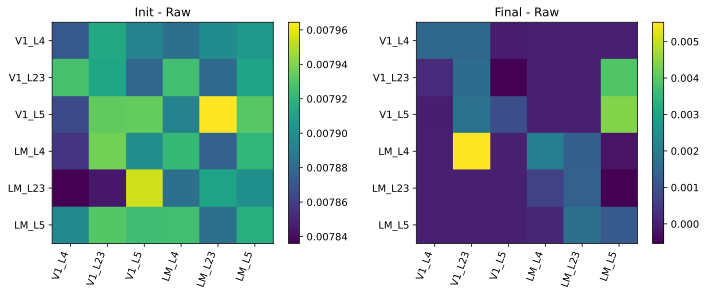

In [61]:
fraw = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_raw_init_layers_pruned[run], cmap='viridis',
           vmin=av_raw_init_layers_pruned[run].min(), vmax=av_raw_init_layers_pruned[run].max(),interpolation='nearest')
plt.title('Init - Raw')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
# plt.clim(0.007,0.01)

plt.subplot(122)
plt.imshow(av_raw_final_layers_pruned[run], cmap='viridis',
           vmin=av_raw_final_layers_pruned[run].min(), vmax=av_raw_final_layers_pruned[run].max(),interpolation='nearest')
plt.title('Final - Raw')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
# plt.clim(0.007,0.01)

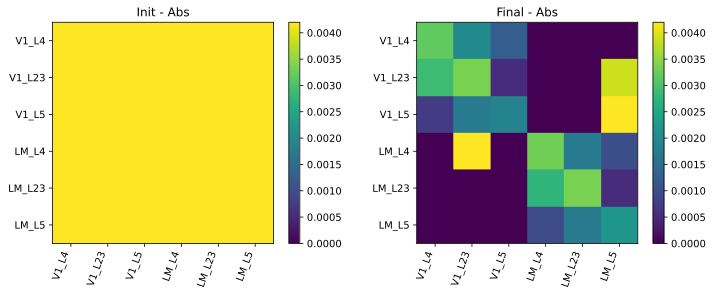

In [62]:
fabs = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_abs_init_layers_pruned[run], cmap='viridis',
           vmin=av_abs_init_layers_pruned[run].min(), vmax=av_abs_init_layers_pruned[run].max(), interpolation='nearest')
plt.title('Init - Abs')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
plt.clim(0.0,0.0042)

plt.subplot(122)
plt.imshow(av_abs_final_layers_pruned[run], cmap='viridis',
           vmin=av_abs_final_layers_pruned[run].min(), vmax=av_abs_final_layers_pruned[run].max(), interpolation='nearest')
plt.title('Final - Abs')
plt.xticks(np.arange(len(label_arr_layers)), label_arr_layers, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_layers)), label_arr_layers)
plt.colorbar()
plt.clim(0.0,0.0042)

In [63]:
av_raw_init_areas_pruned = {}
av_raw_final_areas_pruned = {}

av_abs_init_areas_pruned = {}
av_abs_final_areas_pruned = {}

In [64]:
for cntr in range(nRuns):
    av_raw_init_areas_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_areas, use_absolute_values=False)
    av_raw_final_areas_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_areas, use_absolute_values=False)

    av_abs_init_areas_pruned[cntr] = average_weights_in_blocks_matrix(weights_init[cntr], block_indices_areas, use_absolute_values=True)
    av_abs_final_areas_pruned[cntr] = average_weights_in_blocks_matrix(conn_mtx_final_pruned_retrained[cntr], block_indices_areas, use_absolute_values=True)

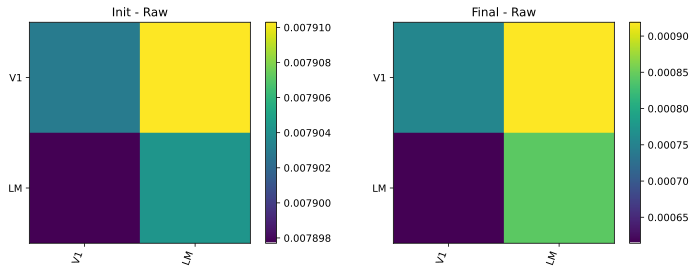

In [65]:
fraw = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_raw_init_areas_pruned[run], cmap='viridis',
           vmin=av_raw_init_areas_pruned[run].min(), vmax=av_raw_init_areas_pruned[run].max(), interpolation='nearest')
plt.title('Init - Raw')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
# plt.clim(0.007,0.01)

plt.subplot(122)
plt.imshow(av_raw_final_areas_pruned[run], cmap='viridis',
           vmin=av_raw_final_areas_pruned[run].min(), vmax=av_raw_final_areas_pruned[run].max(), interpolation='nearest')
plt.title('Final - Raw')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
# plt.clim(0.007,0.01)

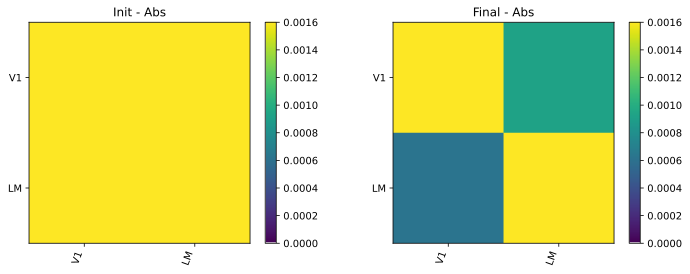

In [66]:
fabs = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(av_abs_init_areas_pruned[run], cmap='viridis',
           vmin=av_abs_init_areas_pruned[run].min(), vmax=av_abs_init_areas_pruned[run].max(), interpolation='nearest')
plt.title('Init - Abs')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
plt.clim(0.0,0.0016)

plt.subplot(122)
plt.imshow(av_abs_final_areas_pruned[run], cmap='viridis',
           vmin=av_abs_final_areas_pruned[run].min(), vmax=av_abs_final_areas_pruned[run].max(), interpolation='nearest')
plt.title('Final - Abs')
plt.xticks(np.arange(len(label_arr_areas)), label_arr_areas, rotation=70, ha='right')
plt.yticks(np.arange(len(label_arr_areas)), label_arr_areas)
plt.colorbar()
plt.clim(0.0,0.0016)

#### Scatter plot heatmap

In [67]:
def create_scatter_heat(matrix, labels):
    # Ensure the input is a square matrix
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"
    assert matrix.shape[0] == len(labels), "The number of labels must match the dimensions of the matrix"

    sources, targets, values = [], [], []

    # Populate sources, targets, and values based on the matrix
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            sources.append(labels[jj]+'_source')
            targets.append(labels[ii]+'_target')
            values.append(matrix[ii,jj])

    # Create a DataFrame
    data = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': values
    })

    # Create the scatterplot heatmap diagram
    # Draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=data,
        x="source", y="target", hue="value", size="value",
        palette="binary", edgecolor=".7")

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)

    return g

In [68]:
av_pop = np.zeros((nRuns,) + av_abs_final_pruned[0].shape)
av_layers = np.zeros((nRuns,) + av_abs_final_layers_pruned[0].shape)
av_areas = np.zeros((nRuns,) + av_abs_final_areas_pruned[0].shape)

In [69]:
for cntr in range(nRuns):
    av_pop[cntr] = av_abs_final_pruned[cntr]
    av_layers[cntr] = av_abs_final_layers_pruned[cntr]
    av_areas[cntr] = av_abs_final_areas_pruned[cntr]

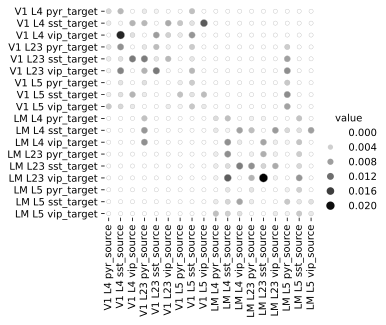

In [70]:
g_pop = create_scatter_heat(np.mean(av_pop,0), label_arr_f) # average over trails

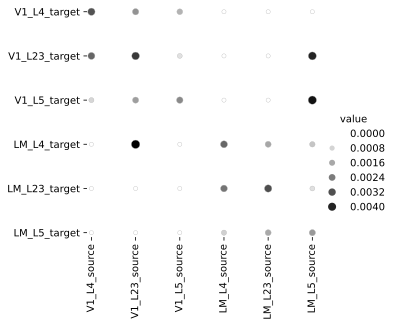

In [71]:
g_layers = create_scatter_heat(np.mean(av_layers,0), label_arr_layers)

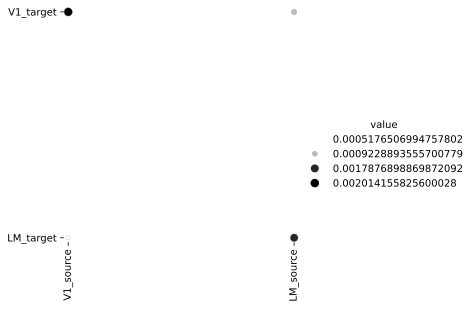

In [72]:
g_areas = create_scatter_heat(np.mean(av_areas,0), label_arr_areas)

#### Scatter plot heatmap : Node size = normalized active connection strength

In [135]:
def create_normalized_scatter_heat(matrix, labels, av_mask):
    # Ensure the input is a square matrix
    assert matrix.shape[0] == matrix.shape[1], "The input matrix must be square"
    assert matrix.shape[0] == len(labels), "The number of labels must match the dimensions of the matrix"
    assert matrix.shape == av_mask.shape, "The input matrix and connection probabilities  must be of same size"

    sources, targets, values, probs = [], [], [], []

    # Populate sources, targets, and values based on the matrix
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            sources.append(labels[jj]+'_source')
            targets.append(labels[ii]+'_target')
            values.append(matrix[ii,jj])
            probs.append(av_mask[ii,jj])

    # Create a DataFrame
    data = pd.DataFrame({
        'source': sources,
        'target': targets,
        'value': values,
        'dispersion': probs
    })

    # Create the scatterplot heatmap diagram
    # Draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=data,
        x="source", y="target", hue="value", size="dispersion",
        palette="binary", edgecolor=".7", legend='brief')

    # Tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)

    bruh = 0
    for handle in g._legend.legend_handles:
        bruh += 1
        if bruh >= 9:
            handle.set_markerfacecolor('none')  # Set marker face color to none for hollow effect
            handle.set_markeredgecolor('black')
            handle.set_markeredgewidth(1.)
    print(bruh)
    return g

In [74]:
av_mask_pop = {}
av_mask_layers = {}
av_mask_areas = {}

In [75]:
for cntr in range(nRuns):
    av_mask_pop[cntr] = average_weights_in_blocks_matrix((np.abs(conn_mtx_final_pruned_retrained[cntr])>0)*1, block_indices)
    av_mask_layers[cntr] = average_weights_in_blocks_matrix((np.abs(conn_mtx_final_pruned_retrained[cntr])>0)*1, block_indices_layers)
    av_mask_areas[cntr] = average_weights_in_blocks_matrix((np.abs(conn_mtx_final_pruned_retrained[cntr])>0)*1, block_indices_areas)

In [76]:
av_mask_pop = np.zeros((nRuns,) + av_mask_pop[0].shape)
av_mask_layers = np.zeros((nRuns,) + av_mask_layers[0].shape)
av_mask_areas = np.zeros((nRuns,) + av_mask_areas[0].shape)

In [77]:
for cntr in range(nRuns):
    av_mask_pop[cntr] = av_mask_pop[cntr]
    av_mask_layers[cntr] = av_mask_layers[cntr]
    av_mask_areas[cntr] = av_mask_areas[cntr]

In [78]:
ng_pop = {}
ng_layers = {}
ng_areas = {}

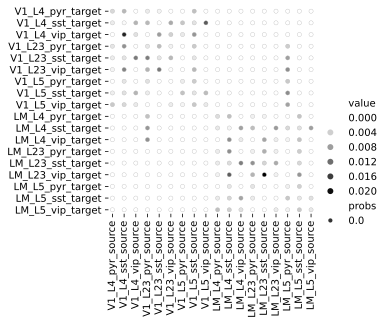

In [91]:
ng_pop = create_normalized_scatter_heat(np.mean(av_pop,0), label_arr, np.mean(av_mask_pop,0))

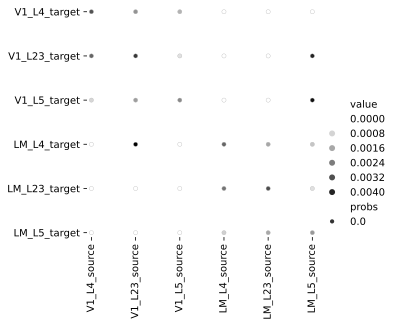

In [80]:
ng_layers = create_normalized_scatter_heat(np.mean(av_layers,0), label_arr_layers, np.mean(av_mask_layers,0))

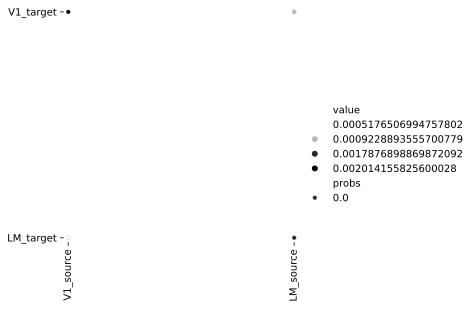

In [81]:
ng_areas = create_normalized_scatter_heat(np.mean(av_areas,0), label_arr_areas, np.mean(av_mask_areas,0))

#### Scatter plot with dispersion and significance

In [131]:
def calculate_dispersion_and_significance(data, dispersion_type):
    """
    Calculate dispersion for each element across multiple runs and their significance.

    Parameters:
    - data: numpy array of shape (nRuns, val1, val2)
    - dispersion_type: str, one of ['std', 'var', 'range', 'iqr', 'cv']

    Returns:
    - dispersion: numpy array of shape (val1, val2)
    - significance: numpy array of p-values with shape (val1, val2)
    """

    # Check if input data is a numpy array
    if not isinstance(data, np.ndarray):
        raise ValueError("Data should be a numpy array")

    # Check if the dispersion_type is valid
    valid_types = ['std', 'var', 'range', 'iqr', 'cv']
    if dispersion_type not in valid_types:
        raise ValueError(f"Dispersion type should be one of {valid_types}")

    # Initialize the output arrays
    val1, val2 = data.shape[1], data.shape[2]
    dispersion = np.zeros((val1, val2))
    significance = np.zeros((val1, val2))

    for ii in range(val1):
        for jj in range(val2):
            values = data[:, ii, jj]
            if dispersion_type == 'std':
                dispersion[ii, jj] = np.std(values)
            elif dispersion_type == 'var':
                dispersion[ii, jj] = np.var(values)
            elif dispersion_type == 'range':
                dispersion[ii, jj] = np.ptp(values)
            elif dispersion_type == 'iqr':
                dispersion[ii, jj] = np.percentile(values, 75) - np.percentile(values, 25)
            elif dispersion_type == 'cv':
                dispersion[ii, jj] =  np.std(values) / np.mean(values) # alternative is 1- dispersion

            # Perform t-test for significance
            t_stat, p_value = ttest_ind(values, values)
            significance[ii, jj] = p_value

    return dispersion, significance

In [133]:
dispersion_type = 'cv'
disp_pop, sig_pop = calculate_dispersion_and_significance(av_pop, dispersion_type)
disp_layers, sig_layers = calculate_dispersion_and_significance(av_layers, dispersion_type)
disp_areas, sig_areas = calculate_dispersion_and_significance(av_areas, dispersion_type)

<ipython-input-131-0aee57eb89ba>:40: RuntimeWarning: invalid value encountered in scalar divide
  dispersion[ii, jj] =  np.std(values) / np.mean(values) # alternative is 1- dispersion


13


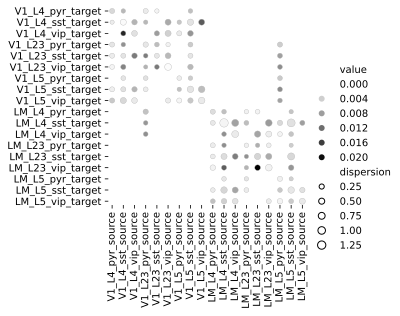

In [136]:
ng_pop = create_normalized_scatter_heat(np.mean(av_pop,0), label_arr, disp_pop)
plt.savefig(store_path +'connectivity/' +suffix+'_confidence.svg', format='svg')

12


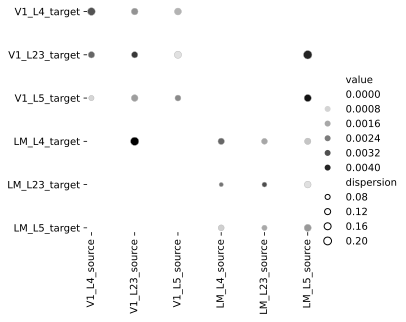

In [137]:
ng_layers = create_normalized_scatter_heat(np.mean(av_layers,0), label_arr_layers, disp_layers)

14


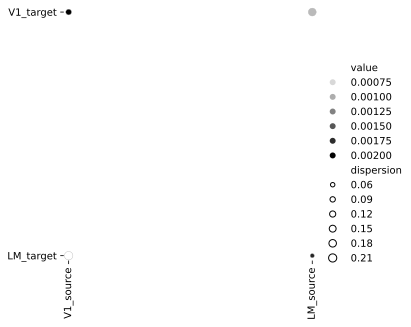

In [138]:
ng_areas = create_normalized_scatter_heat(np.mean(av_areas,0), label_arr_areas, disp_areas)

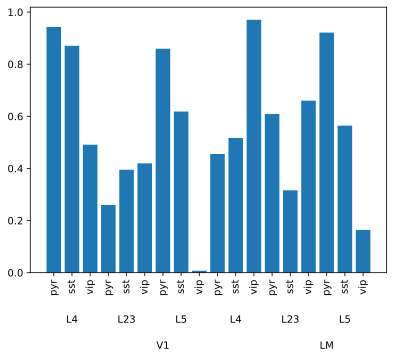

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.random.rand(18)
labels = ['V1_L4_pyr','V1_L4_sst','V1_L4_vip',
          'V1_L23_pyr','V1_L23_sst','V1_L23_vip',
          'V1_L5_pyr','V1_L5_sst','V1_L5_vip',
          'LM_L4_pyr','LM_L4_sst','LM_L4_vip',
          'LM_L23_pyr','LM_L23_sst','LM_L23_vip',
          'LM_L5_pyr','LM_L5_sst','LM_L5_vip']

fig, ax = plt.subplots()
bars = ax.bar(labels, data)

# Adding hierarchical labels
regions = ['V1', 'LM']
layers = ['L4', 'L23', 'L5']
region_ticks = []

for region in regions:
    for layer in layers:
        # Calculate the position for the middle label in each group for the layer label
        middle_index = labels.index(f'{region}_{layer}_pyr') + 1
        ax.text(middle_index, -0.2, layer, ha='center', va='bottom')
        # Store the position for the middle label in each region for the region label
        if layer == 'L5':
            region_ticks.append(middle_index - 1)

# Setting the region labels
for i, region in enumerate(regions):
    ax.text(region_ticks[i], -0.3, region, ha='center', va='bottom')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels([label.split('_')[-1] for label in labels], rotation=90)  # Show only cell types

plt.show()


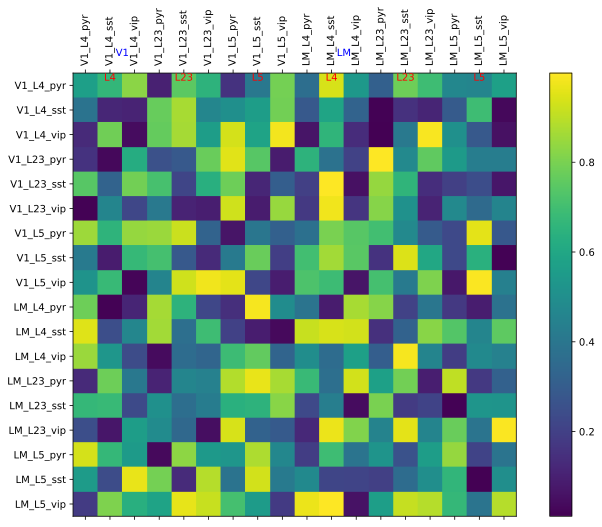

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and hierarchical structure
labels = ['V1_L4_pyr', 'V1_L4_sst', 'V1_L4_vip',
          'V1_L23_pyr', 'V1_L23_sst', 'V1_L23_vip',
          'V1_L5_pyr', 'V1_L5_sst', 'V1_L5_vip',
          'LM_L4_pyr', 'LM_L4_sst', 'LM_L4_vip',
          'LM_L23_pyr', 'LM_L23_sst', 'LM_L23_vip',
          'LM_L5_pyr', 'LM_L5_sst', 'LM_L5_vip']

# Generating a random matrix of size (len(labels), len(labels))
matrix = np.random.rand(len(labels), len(labels))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Creating the heatmap
cax = ax.matshow(matrix, cmap='viridis')

# Adding a color bar
fig.colorbar(cax)

# Set up axis with labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

# Set labels
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate tick labels for better visibility
plt.xticks(rotation=90)

# Extract regions, layers from labels
regions = sorted(set(label.split('_')[0] for label in labels))
layers = sorted(set(label.split('_')[1] for label in labels), reverse=True)

# Place layer labels
layer_labels = [labels.index(f'{region}_{layer}_pyr') + 1 for region in regions for layer in layers]
for idx, layer in enumerate(layers * len(regions)):
    ax.text(layer_labels[idx], -0.5, layer, ha='center', va='top', fontsize=10, color='red')

# Place region labels
region_labels = [labels.index(f'{region}_L4_pyr') + 1.5 for region in regions]
for idx, region in enumerate(regions):
    ax.text(region_labels[idx], -1.5, region, ha='center', va='top', fontsize=10, color='blue')

plt.show()
